# start

## load the dependencies


In [14]:
%pip uninstall -y torchaudio
%pip uninstall -y torch
%pip install torch torchaudio

Found existing installation: torchaudio 2.1.0+cpu
Uninstalling torchaudio-2.1.0+cpu:
  Successfully uninstalled torchaudio-2.1.0+cpu
Note: you may need to restart the kernel to use updated packages.
Found existing installation: torch 2.1.0+cpu
Uninstalling torch-2.1.0+cpu:
  Successfully uninstalled torch-2.1.0+cpu
Note: you may need to restart the kernel to use updated packages.
  Using cached torch-2.7.0-cp311-cp311-win_amd64.whl.metadata (29 kB)
Using cached torch-2.7.0-cp311-cp311-win_amd64.whl (212.5 MB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------------------------------- -- 2.4/2.5 MB 16.8 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 8.9 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   ---------------------------------------- 0/2 [torch]
   -----------------------------------

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio, display
import soundfile as sf
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import random
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F

## loading the data

In [ ]:

train_dir = "/Users/kaispeidel/Downloads/DeepLearning/Train"
train_files = os.listdir(train_dir)


train_df = pd.DataFrame(train_files, columns=['file'])


train_df['file_path'] = train_df['file'].apply(lambda x: os.path.join(train_dir, x).replace("\\", "/"))


train_df['file_name'] = train_df['file'].str.replace('.wav', '', regex=False)


train_df['accent'] = train_df['file_name'].str[0]
train_df['gender'] = train_df['file_name'].str[1]

train_df.to_csv('train_df.csv', index=False)


In [7]:
class Config:
    SAMPLE_RATE = 16000
    N_FFT = 1024
    HOP_LENGTH = 512
    WIN_LENGTH = 1024
    MAX_LENGTH = 5 * SAMPLE_RATE
    AUDIO_DIR = "C:/Users/lucia/OneDrive/Documents/CSAI/Year 3/DeepLearning/assignmnet/DeepLearning copy/DeepLearning copy/Train" 
    METADATA_PATH = "C:/Users/lucia/OneDrive/Documents/CSAI/Year 3/DeepLearning/assignmnet/DeepLearning copy/DeepLearning copy/train_df.csv"  
    

config = Config()

In [ ]:
class AudioPreprocessor:
    def __init__(self, sample_rate=16000, n_mels=128, target_size=(128, 128)):
        self.sample_rate = sample_rate
        self.target_size = target_size
        self.n_mels = n_mels
    
        self.mel_transform = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=2048,
            win_length=1024,
            hop_length=512,
            n_mels=n_mels,
            f_min=20,
            f_max=8000
        )
        self.db_transform = T.AmplitudeToDB(stype='power')
        self.spec_augment = nn.Sequential(
            T.FrequencyMasking(freq_mask_param=30),
            T.TimeMasking(time_mask_param=100)
        )
    
    def extract_features(self, file_path):
        waveform, sr = torchaudio.load(file_path)
        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate)
            waveform = resampler(waveform)
        
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        

        mel_spec = self.mel_transform(waveform)
        mel_spec_db = self.db_transform(mel_spec)
        
        mel_spec_db = (mel_spec_db - mel_spec_db.mean()) / (mel_spec_db.std() + 1e-8)
        
        resized_spec = F.interpolate(
            mel_spec_db.unsqueeze(0),
            size=self.target_size,
            mode='bilinear',
            align_corners=False
        ).squeeze(0)  # Now shape is [C, H, W]
        
        return resized_spec  # Returns [C, H, W] tensor
    
    def apply_augmentation(self, spec):
        return self.spec_augment(spec)

In [9]:
class STFTTransformer:
    def __init__(self, config):
        self.n_fft = config.N_FFT
        self.hop_length = config.HOP_LENGTH
        self.win_length = config.WIN_LENGTH
        
    def transform(self, waveform):
        stft = torch.stft(
            waveform,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=torch.hann_window(self.win_length),
            center=False,
            return_complex=True
        )
        magnitude = torch.abs(stft)
        log_spectrogram = torch.log(magnitude + 1e-6)
        return log_spectrogram

In [10]:
class AccentDataset(Dataset):
    def __init__(self, config, train=True):
        self.config = config
        self.train = train
        self.df = pd.read_csv(config.METADATA_PATH)
        
        self.accent_to_idx = {
            accent: idx for idx, accent in enumerate(sorted(self.df['accent'].unique()))
        }
        self.df['accent_idx'] = self.df['accent'].map(self.accent_to_idx)
        self.preprocessor = AudioPreprocessor(
            sample_rate=config.SAMPLE_RATE,
            target_size=(128, 128)
        )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        filename = row['file_name']
        if not filename.endswith('.wav'):
            filename += '.wav'
        
        file_path = os.path.join(self.config.AUDIO_DIR, filename).replace('\\', '/')
        
        features = self.preprocessor.extract_features(file_path)
        
        if len(features.shape) == 2:
            features = features.unsqueeze(0)
        
        return {
            'features': features,
            'accent': torch.tensor(row['accent_idx'], dtype=torch.long),
            'gender': torch.tensor(0 if row['gender'] == 'm' else 1, dtype=torch.long),
            'file_name': filename
        }

Filename: 1f_1018.wav
Features shape: torch.Size([1, 128, 128])
Accent: 0, Gender: Female


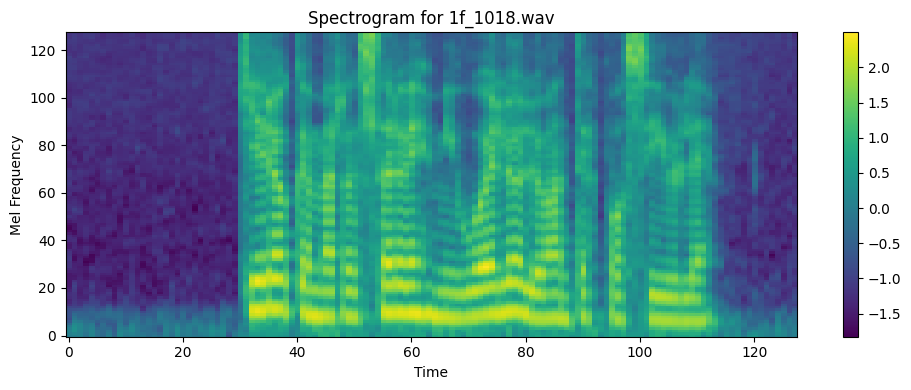

In [11]:
dataset = AccentDataset(config)
sample = dataset[0]

print(f"Filename: {sample['file_name']}")
print(f"Features shape: {sample['features'].shape}")
print(f"Accent: {sample['accent'].item()}, Gender: {'Male' if sample['gender'].item() == 0 else 'Female'}")

def play_audio(file_name, audio_dir):
    path = os.path.join(audio_dir, file_name).replace('\\', '/')
    return Audio(filename=path)

def plot_spectrogram(spec, title="Spectrogram"):
    spec = spec.squeeze().numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(spec, aspect='auto', origin='lower', interpolation='none')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()

play_audio(sample['file_name'], config.AUDIO_DIR)
plot_spectrogram(sample['features'], f"Spectrogram for {sample['file_name']}")


In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class AccentCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [13]:
test_dir = "C:/Users/lucia/OneDrive/Documents/CSAI/Year 3/DeepLearning/assignmnet/DeepLearning copy/DeepLearning copy/Test"
test_files = os.listdir(test_dir)

test_df = pd.DataFrame(test_files, columns=['file'])
test_df['file_path'] = test_df['file'].apply(lambda x: os.path.join(test_dir, x))
test_df['file_name'] = test_df['file'].str.replace('.wav', '')

test_df['accent'] = ''
test_df['gender'] = ''
 

In [14]:
def train_model(config, num_epochs=10, batch_size=32):
    dataset = AccentDataset(config, train=True)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AccentCNN(num_classes=len(dataset.accent_to_idx)).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.001,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader)
    )
    
    best_val_acc = 0.0
    writer = SummaryWriter('runs/enhanced_model')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            features = batch['features'].to(device)  # Already has shape [B, C, H, W]
            labels = batch['accent'].to(device)
            
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * train_correct / train_total
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)  # Already has shape [B, C, H, W]
                labels = batch['accent'].to(device)
                
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        
        writer.add_scalar('Loss/train', train_loss/len(train_loader), epoch)
        writer.add_scalar('Loss/val', val_loss/len(val_loader), epoch)
        writer.add_scalar('Accuracy/train', train_acc, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'enhanced_model_best.pth')
            print('✅ Saved best model')
    
    writer.close()
    return model

In [15]:
enhanced_model = train_model(config, num_epochs=15, batch_size=32)

Epoch 1/15: 100%|██████████| 80/80 [01:39<00:00,  1.25s/it]


Epoch 1/15:
Train Loss: 1.5185, Train Acc: 32.54%
Val Loss: 1.6461, Val Acc: 27.60%
✅ Saved best model


Epoch 2/15: 100%|██████████| 80/80 [01:08<00:00,  1.17it/s]


Epoch 2/15:
Train Loss: 0.9823, Train Acc: 61.33%
Val Loss: 5.1429, Val Acc: 34.38%
✅ Saved best model


Epoch 3/15: 100%|██████████| 80/80 [01:45<00:00,  1.32s/it]


Epoch 3/15:
Train Loss: 0.7507, Train Acc: 70.10%
Val Loss: 1.0304, Val Acc: 63.41%
✅ Saved best model


Epoch 4/15: 100%|██████████| 80/80 [01:59<00:00,  1.50s/it]


Epoch 4/15:
Train Loss: 0.6505, Train Acc: 74.33%
Val Loss: 1.0547, Val Acc: 62.15%


Epoch 5/15: 100%|██████████| 80/80 [05:14<00:00,  3.93s/it]


Epoch 5/15:
Train Loss: 0.5673, Train Acc: 78.08%
Val Loss: 0.7452, Val Acc: 70.50%
✅ Saved best model


Epoch 6/15: 100%|██████████| 80/80 [05:31<00:00,  4.15s/it]


Epoch 6/15:
Train Loss: 0.5762, Train Acc: 77.17%
Val Loss: 0.8711, Val Acc: 69.40%


Epoch 7/15: 100%|██████████| 80/80 [04:55<00:00,  3.69s/it]


Epoch 7/15:
Train Loss: 0.4514, Train Acc: 82.15%
Val Loss: 0.5103, Val Acc: 82.97%
✅ Saved best model


Epoch 8/15: 100%|██████████| 80/80 [05:53<00:00,  4.42s/it]


Epoch 8/15:
Train Loss: 0.3491, Train Acc: 86.33%
Val Loss: 0.4587, Val Acc: 83.91%
✅ Saved best model


Epoch 9/15: 100%|██████████| 80/80 [05:41<00:00,  4.27s/it]


Epoch 9/15:
Train Loss: 0.2804, Train Acc: 89.14%
Val Loss: 0.2613, Val Acc: 90.06%
✅ Saved best model


Epoch 10/15: 100%|██████████| 80/80 [05:54<00:00,  4.44s/it]


Epoch 10/15:
Train Loss: 0.1940, Train Acc: 92.54%
Val Loss: 0.2932, Val Acc: 88.96%


Epoch 11/15: 100%|██████████| 80/80 [05:47<00:00,  4.34s/it]


Epoch 11/15:
Train Loss: 0.1485, Train Acc: 94.87%
Val Loss: 0.2542, Val Acc: 92.11%
✅ Saved best model


Epoch 12/15: 100%|██████████| 80/80 [05:34<00:00,  4.18s/it]


Epoch 12/15:
Train Loss: 0.1432, Train Acc: 95.58%
Val Loss: 0.1733, Val Acc: 93.85%
✅ Saved best model


Epoch 13/15: 100%|██████████| 80/80 [05:32<00:00,  4.16s/it]


Epoch 13/15:
Train Loss: 0.0886, Train Acc: 96.60%
Val Loss: 0.1480, Val Acc: 93.53%


Epoch 14/15: 100%|██████████| 80/80 [05:41<00:00,  4.27s/it]


Epoch 14/15:
Train Loss: 0.0552, Train Acc: 97.83%
Val Loss: 0.1569, Val Acc: 93.69%


Epoch 15/15: 100%|██████████| 80/80 [05:29<00:00,  4.12s/it]


Epoch 15/15:
Train Loss: 0.0607, Train Acc: 97.99%
Val Loss: 0.1510, Val Acc: 94.48%
✅ Saved best model


## 